<a href="https://colab.research.google.com/github/ttjh1234/Study_MLDL/blob/main/chapter05_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#교차 검증과 그리드 서치

이제껏 한 모델평가와 모델링 방법에서는 train_set으로 모델을 훈련시키고,

test_set으로 평가하는 방법을 사용하였다.

하지만 이러한 방법으로 최적의 점수를 맞추도록 모델을 조정한다면, 이 방법 또한 test_set에 맞추는 셈이 된다.

이것은 일반화 성능을 올릴 수 있다고 단언할 수 없다.

가능한 test_set은 모델을 만들고 나서 마지막에 딱 한 번 사용하는 것이 좋다.

따라서 train_set ,test_set을 나눈 후 **train_set의 20%를 valid_set으로 나눈다.**

**과정**

1. train_set으로 모델 훈련
2. valid_set으로 모델 평가 -> 최적의 parameter를 찾기
3. train_set과 valid_set으로 모델 재훈련
4. test_set으로 평가





##검증 세트

데이터는 chapter05_01에서 사용했던 와인데이터를 가지고 사용한다.

데이터는 'https://bit.ly/wine-date' 를 가져와 사용한다.


In [1]:
import pandas as pd
wine_data=pd.read_csv('https://bit.ly/wine-date')

In [3]:
x=wine_data[['alcohol','sugar','pH']].to_numpy()
y=wine_data['class'].to_numpy()
print(x[:5])

[[9.4  1.9  3.51]
 [9.8  2.6  3.2 ]
 [9.8  2.3  3.26]
 [9.8  1.9  3.16]
 [9.4  1.9  3.51]]


먼저 전체 dataset을 train_set과 test_set을 8:2 비율로 나눠준다.

In [4]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

print(x_train.shape)

(5197, 3)


그 후 train_set을 다시 8:2의 비율로 train_sub_set과 valid_set으로 나눠준다.

원래 train_set은 5197개의 데이터가 존재했지만, 분할 후 80%인 4157개의 데이터셋이 되었다.

In [5]:
x_train_sub,x_valid,y_train_sub,y_valid=train_test_split(x_train,y_train,test_size=0.2,random_state=42)

print(x_train_sub.shape,x_valid.shape)

(4157, 3) (1040, 3)


In [7]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier(random_state=42)
dt.fit(x_train_sub,y_train_sub)
print('train_set의 점수 : ',dt.score(x_train_sub,y_train_sub))
print('valid_set의 점수 : ',dt.score(x_valid,y_valid))

train_set의 점수 :  0.9971133028626413
valid_set의 점수 :  0.864423076923077


확실히 아직도 train_set에 대해 **과대적합**이 이루어졌다. 

모형의 매개변수를 조정하여 더 좋은 모델을 찾아야하지만, 검증세트에대해 더 알아보겠다.

##교차 검증

valid_set을 만드느라 train_set의 데이터 수가 줄었다.

보토 많은 데이터를 훈련에 사용할 수록 좋은 모델이 만들어지는데, 그렇다고 검증세트를 너무 조금쓰게 되면 검증 점수가 불안정해진다.

따라서 **교차 검증**을 사용하여 모델을 훈련 및 평가를 진행한다.

교차검증은 검증 세트를 떼어 내어 평가하는 과정을 여러 번 반복한 후, 

이 점수를 평균하여 최종 검증 점수를 얻는다.

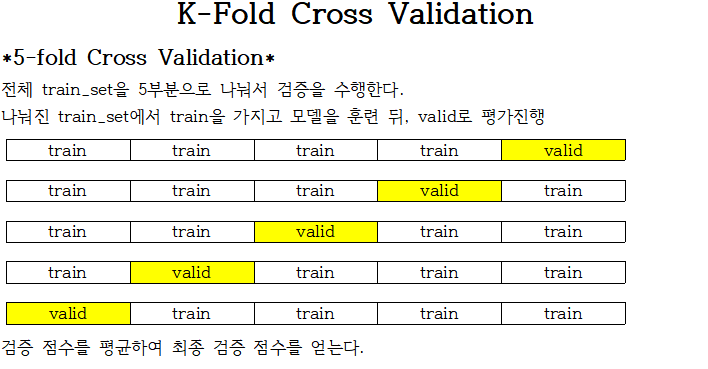

교차 검증은 sklearn.model_selection 의 **cross_validate**를 사용

In [8]:
from sklearn.model_selection import cross_validate
scores=cross_validate(dt,x_train,y_train)
print(scores)

{'fit_time': array([0.00830507, 0.0071466 , 0.00736594, 0.00732923, 0.00698137]), 'score_time': array([0.00080657, 0.00065637, 0.00065565, 0.00068855, 0.00067687]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


cross_validate 는 fit_time,score_time,test_score 키를 가진 딕셔너리를 반환.

fit_time은 모델을 훈련하는 시간

score_time은 모델을 검증하는 시간

test_score은 검증 폴드의 점수

cross_validate() 함수는 기본적으로 5-fold 교차 검증을 수행한다.

cv매개변수에서 폴드 수를 변경할 수 있다.

교차검증의 최종 점수는 test_score에 들어있는 **각 폴드들의 검증 점수들을 평균**하여 얻는다.


In [9]:
import numpy as np
print(np.mean(scores['test_score']))

0.855300214703487


주의할 점은 cross_validate()는 train_set을 섞어서 폴드를 나누지않는다.

앞서 우리는 train_test_split을 통해 전체 dataset을 섞은 후 나누었다.

이미 섞어, 섞을 필요가 없지만, 훈련세트를 섞으려면 **분할기(splitter)**를 지정해야한다.

sklearn의 분할기는 교차 검증에서 폴드를 어떻게 나눌지 결정.

cross_validate 함수는 기본적으로 회귀 모형일 경우, KFold 분할기를 사용,

분류 모형일 경우, 타깃 클래스를 골고루 나누기 위해 StratifiedKFold를 사용.

In [10]:
from sklearn.model_selection import StratifiedKFold
scores=cross_validate(dt,x_train,y_train,cv=StratifiedKFold())
print(np.mean(scores['test_score']))

0.855300214703487


만약 train_set을 섞고, 10-fold 교차 검증을 진행하려면 매개변수를 지정한다.

n_splits는 몇 구간으로 나눌 것인지 지정. (아래에서는 10-fold)

shuffle은 train_set을 섞을 것인지 지정.

In [11]:
spliter=StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
scores=cross_validate(dt,x_train,y_train,cv=spliter)
print(np.mean(scores['test_score']))

0.8574181117533719


##하이퍼 파라미터 튜닝

이제 모델의 파라미터들을 조정하면서 가장 좋은 파라미터들을 찾아야한다.

가령 모델의 파라미터가 1개라면 1개의 python의 반복문을 통해서 해도 되지만,

모델의 파라미터는 대게 2개 이상인 것들이 있다.

각 파라미터들이 서로 독립이면 상관이없겠지만, 독립이 아닌 경우가 대부분이라,

1번 파라미터가 최적인 상태로 2번 파라미터의 최적인 값을 구하는 것은 모델 전체적인 최적값을 구하는게 아니게 된다.

따라서 동시에 바꿔가며 최적의 값을 찾아야한다.

sklearn에서는 **Grid Search**를 제공한다.

sklearn의 **GridSearchCV** 클래스는 하이퍼파라미터 탐색과 교차검증을 동시에 수행한다. 

GridSearchCV의 cv매개변수 기본값은 5이다.

따라서 min_impurity_decrease 값마다 5-fold 교차 검증을 진행하며 총 25개의 모델을 훈련한다.

n_jobs 매개변수는 병렬 실행에 사용할 CPU 코어 수를 지정하는데 기본값은 1이다.

모두 사용하려면 -1을 지정하면 된다.

교차 검증에서 최적의 하이퍼파라미터를 찾으면 전체 훈련세트로 모델을 다시 만들어야한다.

sklearn의 그리드서치는 훈련이 끝나면, 25개의 모델 중에서 검증 점수가 가장 높은 모델의 매개변수 조합으로 전체 훈련 세트에서 자동으로 다시 모델을 훈련한다.

이 모델은 gs 객체의 best_estimator_  속성에 저장되어있다.



In [12]:
from sklearn.model_selection import GridSearchCV
params={'min_impurity_decrease':[0.0001,0.0002,0.0003,0.0004,0.0005]}

In [13]:
gs=GridSearchCV(DecisionTreeClassifier(random_state=42),params,n_jobs=-1)

In [14]:
gs.fit(x_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
    

In [15]:
dt=gs.best_estimator_
print(dt.score(x_train,y_train))

0.9615162593804117


그리드 서치로 찾은 최적의 매개변수는 **best_params_** 속성에 저장되어있다.

또한 각 매개변수에서 수행한 교차 검증의 평균 점수는 **cv_results_**속성의 **mean_test_score**키에 저장되어있다.

In [16]:
print(gs.best_params_)
print(gs.cv_results_['mean_test_score'])

{'min_impurity_decrease': 0.0001}
[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


In [18]:
best_index=np.argmax(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['params'][best_index])

{'min_impurity_decrease': 0.0001}


정리하면,

1. 탐색할 매개변수를 지정
2. train_set에서 gridsearch를 수행하여 최상의 평균점수가 나오는 매개변수 조합을 찾는다.
3. gridsearch의 최상의 매개변수 조합에서 전체 훈련세트를 사용하여 최종 모델을 훈련한다.

이를 통해 결정트리에서 min_impurity_decrease와 max_depth와 min_samples_split의 매개변수를 탐색하겠다.

In [19]:
params={'min_impurity_decrease':np.arange(0.0001,0.001,0.0001),
        'max_depth':range(5,20,1),
        'min_samples_split':range(2,100,5)
        }


In [20]:
gs=GridSearchCV(DecisionTreeClassifier(random_state=42),params,n_jobs=-1)
gs.fit(x_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'm

In [21]:
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 7}


In [22]:
dt=gs.best_estimator_
print(dt.score(x_train,y_train))

0.8930152010775447


In [23]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8687708225364625


## 랜덤 서치

사실 매개변수의 값이 수치일 때 값의 범위나 간격을 둔 것에 근거가없다.

즉, 설정한 범위보다 더 좋은 최적의 parameter가 있을 수 있는 것이다.

위 조건에서 매개변수 조건이 너무 많아 총 9\*15\*20\*5로 총 13500개의 모델을 만들었다.

수행 시간이 굉장히 오래걸렸는데, 이런 경우 **랜덤 서치(Random Search)**를 사용하면 좋다.

랜덤 서치에서는 **매개변수 값의 배열(목록)을 전달하는 것이 아니라, 확률 분포 객체를 전달한다.**

In [25]:
from scipy.stats import uniform,randint

확률 분포 객체로서 scipy.stats에 있는 uniform, randint 클래스를 가져온다.

randint(a,b) : a\~b까지의 정수를 뽑는다.

uniform(a,b) : a\~b까지의 실수를 뽑는다.

In [26]:
rgen=randint(0,10)
rgen.rvs(10)

array([7, 9, 6, 4, 6, 1, 0, 5, 1, 5])

In [27]:
np.unique(rgen.rvs(1000),return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([101, 102, 107, 106, 109, 102,  89,  92,  91, 101]))

In [28]:
ugen=uniform(0,1)
ugen.rvs(10)

array([0.11973145, 0.21110764, 0.66077538, 0.47072075, 0.4370037 ,
       0.33588767, 0.32743592, 0.84048506, 0.6932206 , 0.31537179])

앞서 했었던 결정트리의 세가지 변수에 min_samples_leaf를 추가하여 

하이퍼파라미터 튜닝을 해보겠다.

RandomSearch는 sklearn.model_selection의 **RandomizedSearchCV**클래스를 이용한다.

In [29]:
params={'min_impurity_decrease':uniform(0.0001,0.001),
        'max_depth':randint(20,50),
        'min_samples_split':randint(2,25),
        'min_samples_leaf':randint(1,25)
        }

In [30]:
from sklearn.model_selection import RandomizedSearchCV
rs=RandomizedSearchCV(DecisionTreeClassifier(random_state=42),params,n_iter=100,n_jobs=-1,random_state=42)
rs.fit(x_train,y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=42,
         

In [31]:
print(rs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


In [33]:
print(np.max(rs.cv_results_['mean_test_score']))

0.8695428296438884


In [34]:
dt=rs.best_estimator_
print(rs.score(x_test,y_test))

0.86
